## Data 620 - Project 1

Baron Curtin, Heither Geiger

## Introduction

For this project, we will be using data containing the networks of 10 different Facebook users (aka the "ego nodes"). This data will be downloaded from the Stanford Large Network Dataset Collection. The dataset is available here: https://snap.stanford.edu/data/ego-Facebook.html.

Here, each node ID represents a Facebook user.

For each of the 10 different networks (denoted by the ID of the user at the center of the network), we have the following files:

\*.edges - Each line will have two columns. The node IDs in column 1 and column 2 are connected to each other and to the ego node.

\*.circles - Each line will have an ID column (i.e. circle0, circle1, and so on), followed by anywhere from one to 100+ additional columns. The circles represent groups of users. Each node ID in every field of every line is connected to the ego node.

\*.featnames - Gives more info about which feature corresponds to each feature column. For example, "8 education;classes;id;anonymized feature 8" means that column 9 of the features file (with 0-based indexing) corresponds to an anonymized feature related to education (specifically, classes taken). 

\*.egofeat and \*.feat - For each feature explained in featnames, give whether the feature is true or false in each user for the ego node and all other nodes respectively.

In [1]:
# load libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import combinations

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# create a constant for debugging to reduce size of graph
DEBUG = True

## Data Loading/Parsing

In the following code cells, we will be loading the data into Python and preparing it to be visualized with NetworkX


In [2]:
fb_path = Path('../week3/facebook')
file_types = ('circles', 'edges', 'egofeat', 'feat', 'featnames')

# load all files into python dictionary by file type
files = {file_type: [(f.stem, f) for f in fb_path.glob(f'*{file_type}')] for file_type in file_types}

Now that all of the files are loaded, we need to create a function that will parse each file appropriately


### File Parsing Functions

In [3]:
def circles_parser(lines='', **kwargs):
    # circles files are tab delimited
    info = [(int(kwargs['node']), int(n))
            for l in lines 
            for n in l.split('\t')[1:]
            if l != '']
    return info

def edges_parser(lines='', **kwargs):
    # edges files are separated by spaces
    info = [x for l in lines
            for x in combinations([*l.split(' '), kwargs['node']], 2)
            if l != '']
    return info

def egofeat_parser(lines='', **kwargs):
    # egofeat is separated by spaces
    info = [x for l in lines
            for x in l.split(' ')
            if l != '']
    return info

def feat_parser(lines='', **kwargs):
    # feat files are separated by spaces
    info = [(l.split(' ')[0], l.split(' ')[1:]) 
            for l in lines
            if l != '']
    return info

def featnames_parser(lines='', **kwargs):
    # featnames files are delimited by ;
    # we will only use the first index and the last index of the featurename
    # as there are inconsistencies in length
    info = [(l.split(';')[0], l.split(';')[-1])
            for l in lines]
    return info


# dictionary of file parsing functions for easy referencing later
# using a dictionary will serve as a 'case' function
file_parsers = {
    'circles': circles_parser,
    'edges': edges_parser,
    'egofeat': egofeat_parser,
    'feat': feat_parser,
    'featnames': featnames_parser
}

In [4]:
def parse_file(file_, node, file_type=''):
    # basic error handling to make sure all required arguments are passed
    if (file_ is None) | (node == '') | (file_type == ''):
        raise ValueError('Unable to parse file without the required information')
    
    # get contents of the file
    content = file_.read_text()
    lines = content.split('\n')
    
    # reduce size of lines base on debug
    if DEBUG:
        lines = lines[:20] if len(lines) > 20 else lines
    
    # parse based on file type
    info = file_parsers[file_type](lines, node=node)
    return info

In [5]:
# we can use our created functions to create a new dictionary of parsed files
parsed_files = {file_type: {node: parse_file(file_path, node, file_type) for node, file_path in list_of_files}
                for file_type, list_of_files in files.items()}

### Parsing the Categorical Feature (Gender)

Each "ego node" has a file with a ".feat" extension. The ".featnames" file maps the columns in the ".feat" file with the column name.
We will only take the columns given a distinction for gender from each ".feat" file.

## Graph Construction

In [6]:
g = nx.Graph()

# add edges from all the edges files
g.add_edges_from([y for x in parsed_files['circles'].values()
                  for y in x])

# add edges from all the circles files
g.add_edges_from([y for x in parsed_files['edges'].values()
                  for y in x])

# set node attributes
# nx.set_node_attributes(g, , 'gender')

<Figure size 3600x1440 with 0 Axes>

/Users/baron.curtin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-0.8484042941183083,
 1.0754030937281345,
 -0.6668501824449532,
 1.0795302274946534)

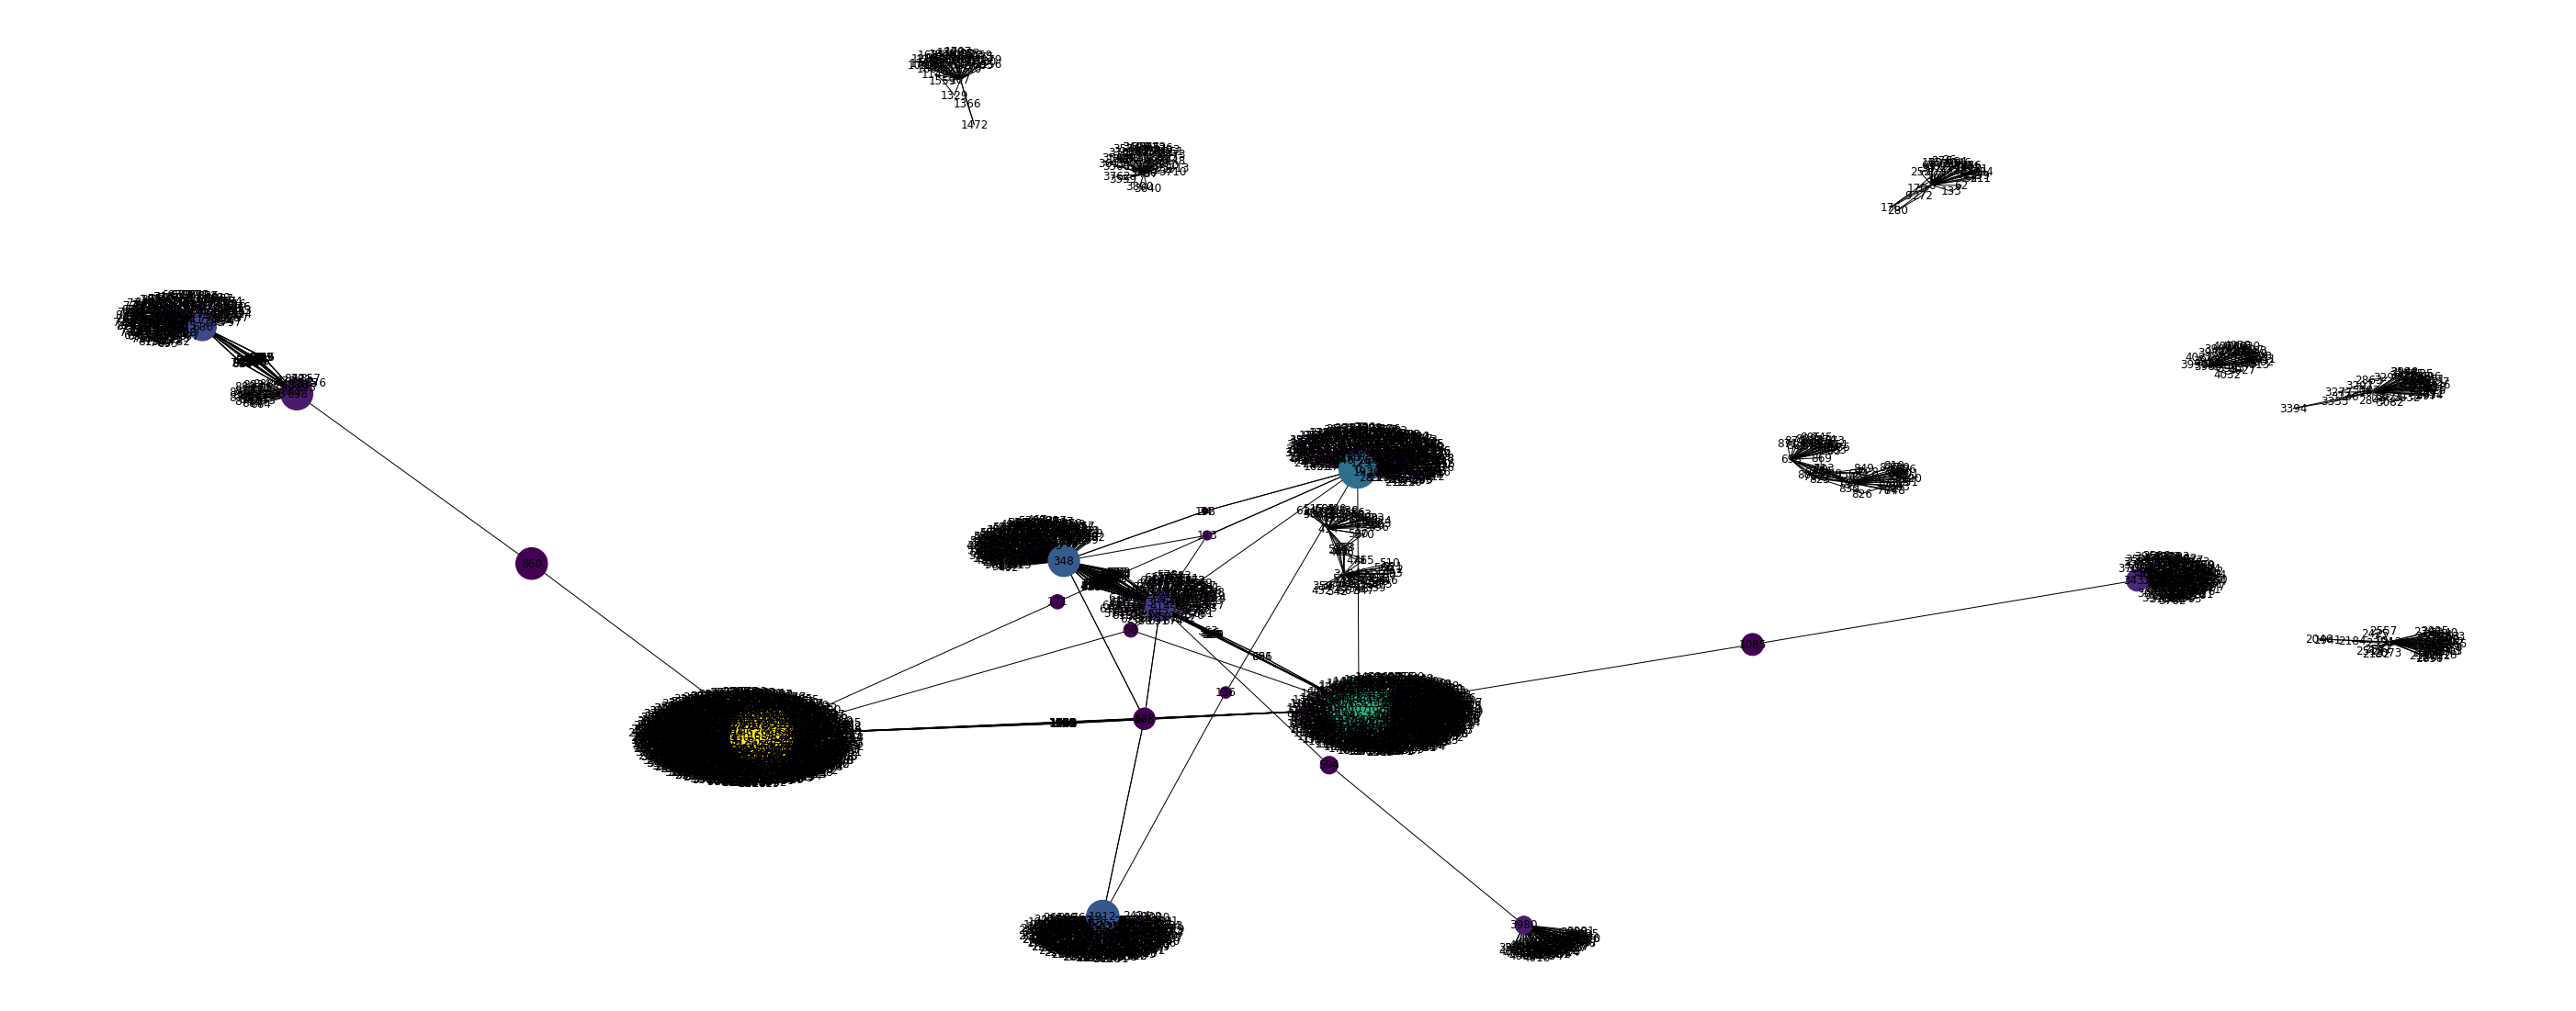

In [7]:
pos = nx.spring_layout(g)
bet_centrality = nx.betweenness_centrality(g, normalized=True, endpoints=True)
node_color = [10000.0 * g.degree(v) for v in g]
node_size = [v * 10000.0 for v in bet_centrality.values()]

plt.figure(figsize=(50,20))
nx.draw_networkx(g, pos=pos, node_color=node_color, node_size=node_size)
plt.axis('off')

## Network Analysis